In [1]:
from __future__ import print_function, division
import os
import sys

import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv, find_dotenv
%matplotlib inline

print('sys_version', sys.version.replace('\n', ''))
print('virtual_env', os.environ.get('VIRTUAL_ENV', 'None'))
print('pwd', os.getcwd())
print('np ', np.__version__)
print('pd ', pd.__version__)

logging.getLogger().setLevel(logging.INFO)

sys_version 3.5.2 (default, Nov 17 2016, 17:05:23) [GCC 5.4.0 20160609]
virtual_env None
pwd /home/marko/nmiculinic/minion/notebook
np  1.12.1
pd  0.20.1


/usr/local/lib/python3.5/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
sys.path.append('/home/marko/repos/minion/')

from mincall import align_utils, bioinf_utils
from mincall.align_utils import filter_aligments_in_sam, read_len_filter, secondary_aligments_filter, only_mapped_filter, supplementary_aligments_filter
from mincall.bioinf_utils import error_rates_for_sam
from mincall.consensus import get_consensus_report
import pysam

## Align with graphmap

### Merge .fa files into single .fa
- how to merge reads, mselak demo

In [4]:
from mincall.align_utils import merge_reads, cnt_sequences_in_fastx

reads_root_dir = '/data/mara/'
single_reads_file = '/data/mara/total/all.fa'

merge_reads(reads_root_dir, single_reads_file)

### define reference

In [5]:
ref_path = '/data/references/NC_001416.fa'
is_circular = True

### run graphmap

In [6]:
from mincall.align_utils import align_with_graphmap

out_sam_path = '/data/sams/lambda/resdeep.sam'
single_reads_file = '/data/basecalled/fastx/lambda_R9/resdeep.fa'
align_with_graphmap(single_reads_file, ref_path, is_circular, out_sam_path)

INFO:root:Graphmap exit status 0


### run bwa mem

- no extended cigar option by default

In [7]:
from mincall.align_utils import align_with_bwa_mem

out_sam_path = '/data/mara/lambda_bwa.sam'
align_with_bwa_mem(single_reads_file, ref_path, is_circular, out_sam_path)

INFO:root:Removing /data/mara/lambda_bwa.sam
INFO:root:bwa mem align exit status 0
18reads [00:00, 56.49reads/s]WARNING:root:read Andrej_HC_20160706_FNFAD12873_MN17271_sequencing_run_lambda_R9_6_7_16_21932_ch299_read971_strand is unmapped, copy to out sam as is
100reads [00:00, 104.72reads/s]


## Example how to filter reads in sam

In [8]:
from mincall.align_utils import filter_aligments_in_sam, read_len_filter, secondary_aligments_filter, only_mapped_filter, supplementary_aligments_filter

# out path
sam_path =  '/data/sams/lambda/resdeep.sam'
filtered_path = '/data/sams/filtered.sam'

def dummy_filter():
    def _filter(x):
        return True
    return _filter

# define list of filters (functions that take pysam.AlignedSegment and return boolean)
filters = [
    #read_len_filter(max_len=400),# read_len_filter(max_len=400),
    only_mapped_filter(), #secondary_aligments_filter(), supplementary_aligments_filter(),
    dummy_filter()
]

n_kept, n_discarded = filter_aligments_in_sam(sam_path, filtered_path, filters)
print("Kept %d, discarded %d" % (n_kept, n_discarded))

Kept 98, discarded 1


In [9]:
sam_path = filtered_path

## Error rates

In [10]:
from mincall.bioinf_utils import error_rates_for_sam

df = error_rates_for_sam(sam_path)
df.describe(percentiles=[]).transpose()


98read [00:00, 464.32read/s]


,count,mean,std,min,50%,max
Error %,98.0,29.561467,13.482641,0.000000,24.723320,56.500977
Match %,98.0,85.062055,11.565720,45.454545,88.886813,100.000000
Mismatch %,98.0,9.012976,5.026219,0.000000,7.593850,36.363636
Insertion %,98.0,5.924969,8.100230,0.000000,3.190177,37.931034
Deletion %,98.0,14.623522,9.156476,0.000000,11.529988,40.356798
Identity %,98.0,65.532861,26.794836,0.037779,73.898934,86.836571
Read length,98.0,5235.561224,2646.038062,462.000000,5293.500000,11618.000000


## CIGAR operations - position analysis

In [11]:
from mincall.bioinf_utils import error_positions_report

position_report = error_positions_report(sam_path, n_buckets=100)
position_report.head()

,relative_position,operation,op_count
0,0.0,D,325
1,0.0,X,540
2,0.0,I,654
3,0.0,=,3189
4,0.0,S,1163


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


AttributeError: Unknown property weights

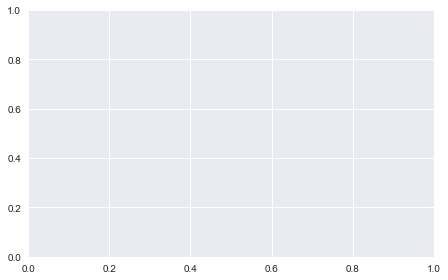

In [12]:
def plot_error_distributions(position_report):
    plt.figure(figsize=(16,10))

    #n_graphs = len(CIGAR_OPERATIONS)
    n_cols = 2
    n_rows = 2#np.ceil(n_graphs/2)

    label = {
        '=':'Match',
        'X':'Missmatch',
        'I': "Insertion",
        'D': 'Deletion'
    }
    for i, op in enumerate(['=', 'X', 'I', 'D']):
        data = position_report[position_report.operation == op]
        data.op_count /= data.op_count.sum()
        data.op_count *= 100
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(data.relative_position, weights=data.op_count, shade=False, label=op, alpha=0.5)
        #plt.plot(data.relative_position, data.op_count)
        plt.xlim((0, 1))

        plt.xlabel('relative position')
        plt.ylabel('percentage %')
        plt.title(label[op])
plot_error_distributions(position_report)
plt.show()

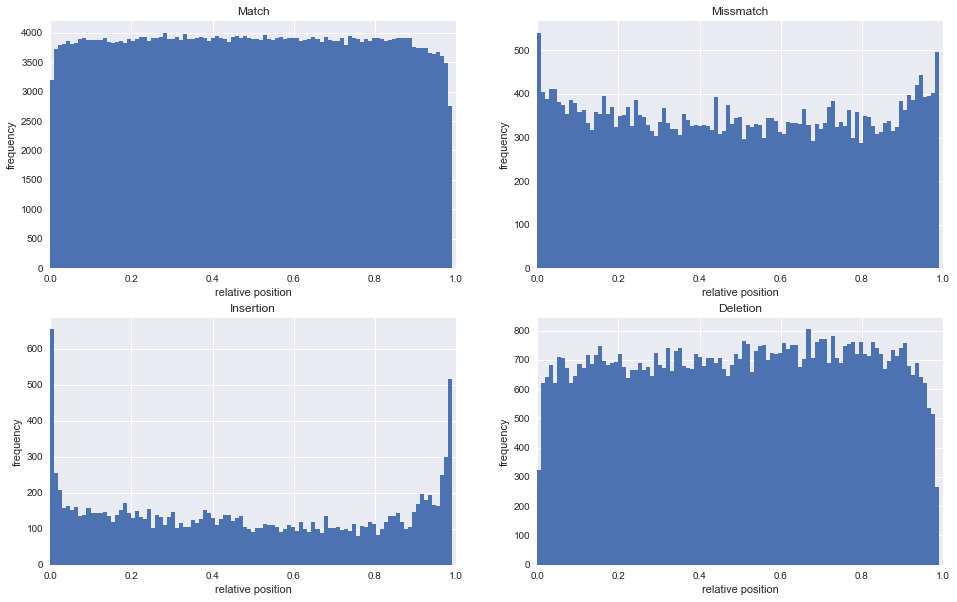

In [13]:
from mincall.bioinf_utils import CIGAR_OPERATIONS

def plot_error_distributions(position_report):
    plt.figure(figsize=(16,10))

    n_graphs = len(CIGAR_OPERATIONS)
    n_cols = 2
    n_rows = 2#np.ceil(n_graphs/2)

    label = {
        '=':'Match',
        'X':'Missmatch',
        'I': "Insertion",
        'D': 'Deletion'
    }
    for i, op in enumerate(['=', 'X', 'I', 'D']):
        data = position_report[position_report.operation == op]

        plt.subplot(n_rows, n_cols, i+1)
        plt.hist(data.relative_position, bins=100, weights=data.op_count)
        #plt.plot(data.relative_position, data.op_count)
        plt.xlim((0, 1))

        plt.xlabel('relative position')
        plt.ylabel('frequency')
        plt.title(label[op])
        
plot_error_distributions(position_report)
plt.show()

## Consensus stats

In [14]:
from mincall.consensus import get_consensus_report


import importlib
from mincall import consensus
importlib.reload(consensus)
from mincall import consensus
from mincall.consensus import get_consensus_report


In [15]:
sam_path

'/data/sams/filtered.sam'

In [16]:
report_out_dir = '/data/reports/' #dir for vcf and csv files
tmp_files_dir = '/data/reports/tmp' #tmp dir for bam, bai and mpilup files
coverage_threshold = 0

# Arguments for storing detailed data
#report = get_consensus_report('mincall', sam_path, ref_path, is_circular, coverage_threshold, report_out_dir, tmp_files_dir)
report = get_consensus_report('mincall', sam_path, ref_path, is_circular, coverage_threshold)

INFO:root:Split long aligments
INFO:root:Converting sam to bam
INFO:root:Sorting bam file
INFO:root:Creating bam index
INFO:root:Creating mpileup
INFO:root:Generating consensus and report
100%|██████████| 48502/48502 [00:02<00:00, 19856.16it/s]
INFO:root:Cleaning tmp files


In [17]:
report.transpose()

,mincall
alignments_file,/data/sams/filtered.sam
mpileup_file,/tmp/tmp5ykme418/filtered.bam.bam.mpilup
coverage_threshold,0
snp_count,291
insertion_count,4
deletion_count,114
num_undercovered_bases,0
num_called_bases,48372
num_correct_bases,48077
average_coverage,10.0702


In [18]:
import pysam
import pandas as pd


def load_vcf_file(vcf_path):
    data = []
    with pysam.VariantFile(vcf_path, 'r') as vcf_in:
        for rec in vcf_in.fetch():
            old, new = rec.alleles
            data.append([rec.pos, rec.info['TYPE'][0], old, new, rec.info['DP']])

    df = pd.DataFrame(data, columns=['pos', 'type', 'from_bases', 'to_bases', 'coverage']) 
    df.set_index('pos', inplace=True)
    return df
    
vcf_path = '/data/reports/cov_0.variant.vcf'
vcf_stats = load_vcf_file(vcf_path)
vcf_stats.head()

,type,from_bases,to_bases,coverage
pos,,,,
46338,del,CG,C,1
46344,snp,T,C,1
46350,del,ACC,A,1
46353,del,CT,C,1
46355,del,CA,C,1


# Analysis

## define dataset

In [19]:
dataset = 'ecoli_r9'
ref = '/data/references/escherichia_coli.fa'
is_circular = False

data_dir = '/data/basecalled/fastx/'
sam_data_dir = '/data/basecalled/sam/'
basecallers = ['deepnano', 'nanonet', 'metrichor', 'resdeep', 'albacore']

coverage_threshold = 1
out_dir = os.path.join('/data/tmp/', dataset)
os.makedirs(out_dir, exist_ok=True)


In [20]:
dfs = {}
consensus_reports = []


def align(name, fx_file):        
    sam_path = os.path.join(sam_data_dir, dataset, name + ".sam")

    if os.path.isfile(sam_path):
        logging.info("%s exists, skipping", sam_path)
    else:
        logging.info("Aligning %s to reference %s with graphmap", fx_file, ref)
        align_utils.align_with_graphmap(fx_file, ref, is_circular, sam_path)
        
    return sam_path


def filter_alignments(name, sam_path):
    os.makedirs(os.path.join(sam_data_dir, dataset, 'filtered'), exist_ok=True)
    filtered_sam = os.path.join(sam_data_dir, dataset, 'filtered', name + "_filtered.sam")
    
    if os.path.isfile(filtered_sam):
        logging.info("%s exists, skipping", filtered_sam)
    else:
        filters = [only_mapped_filter()]
        n_kept, n_discarded = filter_aligments_in_sam(sam_path, filtered_sam, filters)
        logging.info("Outputed filtered sam to %s\n%d kept, %d discarded", filtered_sam, n_kept, n_discarded)
    return filtered_sam


def error_rates(name, sam_path):
    reads_pkl = os.path.join(out_dir, name + "_read_data.pkl")
    if os.path.isfile(reads_pkl):
        logging.info("%s file exists, loading", reads_pkl)
        df = pd.read_pickle(reads_pkl)
    else:
        df = error_rates_for_sam(sam_path)
        df.to_pickle(reads_pkl)
        
    return df

def run_consensus_report(name, sam_path):
    consensus_report_path = os.path.join(out_dir, name + "_consensus_report.pkl")
    if os.path.isfile(consensus_report_path):
        consensus_report = pd.read_pickle(consensus_report_path)
        logging.info("%s exists, loading", consensus_report_path)
    else:
        consensus_report = get_consensus_report(name, sam_path, ref, coverage_threshold)
        consensus_report.to_pickle(consensus_report_path)
    return consensus_report


def fill_additional_stats(consensus_report, df):
    # additional stats
    pass
    
def homopolimers_stats(fx_file):
    with pysam.FastxFile(fx_file, 'r') as fh:
        lens = []
        for x in fh:
            seq = x.sequence
            l = 1
            for prev, nxt in zip(seq, seq[1:]):
                if prev == nxt:
                    l += 1
                else:
                    lens.append(l)
                    l = 1
    lens = np.array(lens)
    lens = lens[lens > 4]
    return lens.mean(), lens.std()

    
repetitions = []
for name in basecallers:
    fx_file = os.path.join(data_dir, dataset, name + '.fa')
    if not os.path.exists(fx_file):
        fx_file = os.path.join(data_dir, dataset, name + '.fq')
        
    sam_path = align(name, fx_file)
    filtered_sam = filter_alignments(name, sam_path)
    df = error_rates(name, filtered_sam)
    

    desc = df.describe()
    desc.to_latex(os.path.join(out_dir, name + "_read_summary.tex"))
    dfs[name] = df
    
    consensus_report = run_consensus_report(name, filtered_sam)
    fill_additional_stats(consensus_report, df)

    consensus_reports.append(consensus_report)
    mean, std = homopolimers_stats(fx_file)
    repetitions.append((name, mean, std))

repetitions = pd.DataFrame(repetitions, columns=['name', 'mean', 'std'])
consensus_reports = pd.concat(consensus_reports)
logging.info("Consensus Reports \n%s", consensus_reports)
consensus_reports.to_csv(os.path.join(out_dir, "consensus.csv"))
consensus_reports.to_latex(os.path.join(out_dir, "consensus.tex"))


INFO:root:/data/basecalled/sam/ecoli_r9/deepnano.sam exists, skipping
INFO:root:/data/basecalled/sam/ecoli_r9/filtered/deepnano_filtered.sam exists, skipping
INFO:root:/data/tmp/ecoli_r9/deepnano_read_data.pkl file exists, loading
INFO:root:/data/tmp/ecoli_r9/deepnano_consensus_report.pkl exists, loading
INFO:root:/data/basecalled/sam/ecoli_r9/nanonet.sam exists, skipping
INFO:root:/data/basecalled/sam/ecoli_r9/filtered/nanonet_filtered.sam exists, skipping
INFO:root:/data/tmp/ecoli_r9/nanonet_read_data.pkl file exists, loading
INFO:root:/data/tmp/ecoli_r9/nanonet_consensus_report.pkl exists, loading
INFO:root:/data/basecalled/sam/ecoli_r9/metrichor.sam exists, skipping
INFO:root:/data/basecalled/sam/ecoli_r9/filtered/metrichor_filtered.sam exists, skipping
INFO:root:/data/tmp/ecoli_r9/metrichor_read_data.pkl file exists, loading
INFO:root:/data/tmp/ecoli_r9/metrichor_consensus_report.pkl exists, loading
INFO:root:/data/basecalled/sam/ecoli_r9/resdeep.sam exists, skipping
INFO:root:/da

In [21]:
consensus_reports

,alignments_file,mpileup_file,coverage_threshold,snp_count,insertion_count,deletion_count,num_undercovered_bases,num_called_bases,num_correct_bases,average_coverage,Snp %,Insertion %,Deletion %,Match %,undercovered_rate,identity_percentage
deepnano,/data/basecalled/sam/ecoli_r9/filtered/deepnan...,/tmp/tmpcp04ws57/deepnano_filtered.bam.bam.mpilup,0,15169.0,1833.0,13654.0,0.0,1510244.0,1493242.0,5.763877,1.004407,0.121371,0.904092,98.874222,32.184194,32.184194
nanonet,/data/basecalled/sam/ecoli_r9/filtered/nanonet...,/tmp/tmpl7pxqeoz/nanonet_filtered.bam.bam.mpilup,0,22204.0,6518.0,21437.0,0.0,1414237.0,1385515.0,3.319410,1.570034,0.460885,1.515800,97.969082,29.862329,29.862329
metrichor,/data/basecalled/sam/ecoli_r9/filtered/metrich...,/tmp/tmptwf7d29y/metrichor_filtered.bam.bam.mp...,0,11314.0,1991.0,9550.0,0.0,1515893.0,1502588.0,6.117218,0.746359,0.131342,0.629992,99.122300,32.385630,32.385630
resdeep,/data/basecalled/sam/ecoli_r9/filtered/resdeep...,/tmp/tmpsuyzw146/resdeep_filtered.bam.bam.mpilup,0,9827.0,1768.0,8363.0,0.0,1517828.0,1506233.0,6.125529,0.647438,0.116482,0.550985,99.236079,32.464192,32.464192
albacore,/data/basecalled/sam/ecoli_r9/filtered/albacor...,/tmp/tmpe9tsxo79/albacore_filtered.bam.bam.mpilup,0,10212.0,3494.0,5524.0,0.0,1523031.0,1509325.0,6.149300,0.670505,0.229411,0.362698,99.100084,32.530835,32.530835


In [22]:
consensus_reports = consensus_reports[consensus_reports.columns[3:]]
consensus_reports

,snp_count,insertion_count,deletion_count,num_undercovered_bases,num_called_bases,num_correct_bases,average_coverage,Snp %,Insertion %,Deletion %,Match %,undercovered_rate,identity_percentage
deepnano,15169.0,1833.0,13654.0,0.0,1510244.0,1493242.0,5.763877,1.004407,0.121371,0.904092,98.874222,32.184194,32.184194
nanonet,22204.0,6518.0,21437.0,0.0,1414237.0,1385515.0,3.319410,1.570034,0.460885,1.515800,97.969082,29.862329,29.862329
metrichor,11314.0,1991.0,9550.0,0.0,1515893.0,1502588.0,6.117218,0.746359,0.131342,0.629992,99.122300,32.385630,32.385630
resdeep,9827.0,1768.0,8363.0,0.0,1517828.0,1506233.0,6.125529,0.647438,0.116482,0.550985,99.236079,32.464192,32.464192
albacore,10212.0,3494.0,5524.0,0.0,1523031.0,1509325.0,6.149300,0.670505,0.229411,0.362698,99.100084,32.530835,32.530835


In [23]:
error_rates_report = []

columns = ['Error %', 'Match %', 'Mismatch %', 'Insertion %',
       'Deletion %', 'Identity %', 'Read length']

for name in dfs.keys():
    df = dfs[name]
    report = pd.DataFrame()
    report['Basecaller'] = [name]
    for column in columns:
        report[column+'(median)'] = [df[column].median()]
    error_rates_report.append(report)
    
error_rates_report = pd.concat(error_rates_report)
error_rates_report

,Basecaller,Error %(median),Match %(median),Mismatch %(median),Insertion %(median),Deletion %(median),Identity %(median),Read length(median)
0,resdeep,16.271057,91.408591,5.019141,3.477739,7.471608,84.615385,5784.0
0,deepnano,21.749124,90.254762,6.452852,3.274420,11.829965,80.396245,5526.5
0,metrichor,17.953102,90.560455,5.688105,3.660381,8.328271,83.148088,5809.5
0,nanonet,17.833581,90.607674,5.608912,3.652791,8.299046,83.110264,3286.5
0,albacore,18.273099,87.446674,5.852702,6.597637,5.546608,82.445598,6175.0


['Error %', 'Match %', 'Mismatch %', 'Insertion %', 'Deletion %', 'Identity %', 'Read length', 'Is reversed']


INFO:root:Plotting column Error %
INFO:root:Plotting column Match %
INFO:root:Plotting column Mismatch %
INFO:root:Plotting column Insertion %
INFO:root:Plotting column Deletion %
INFO:root:Plotting column Identity %


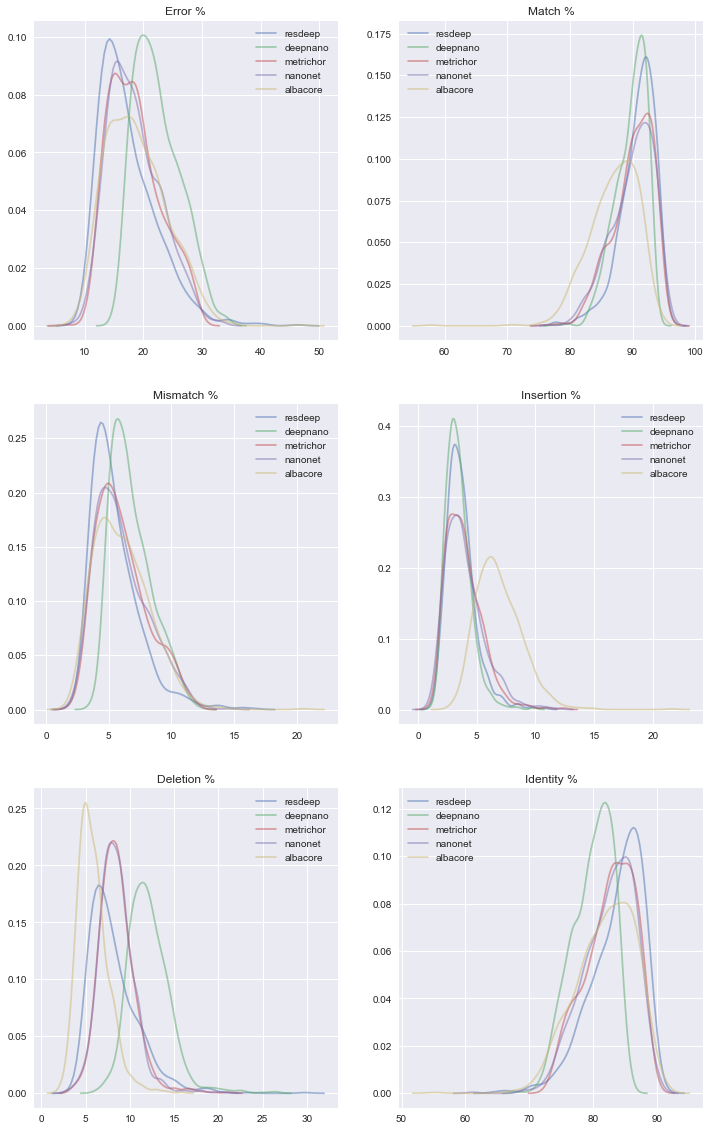

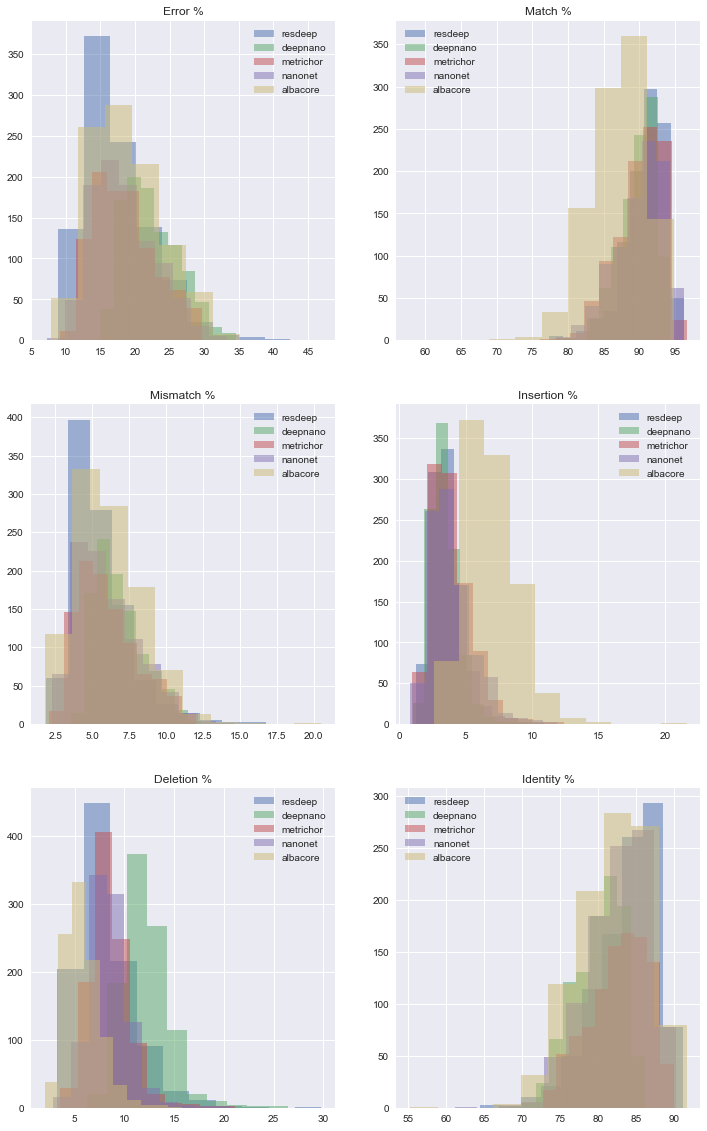

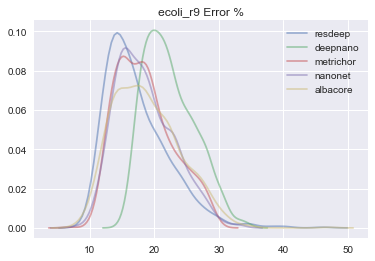

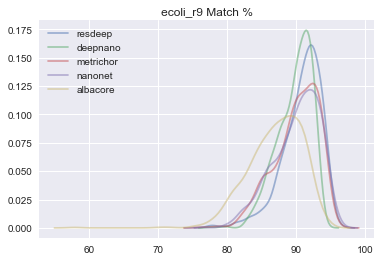

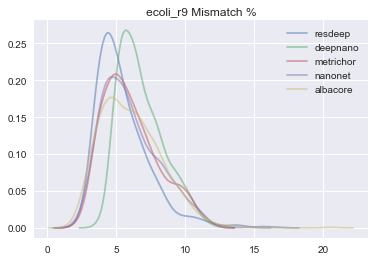

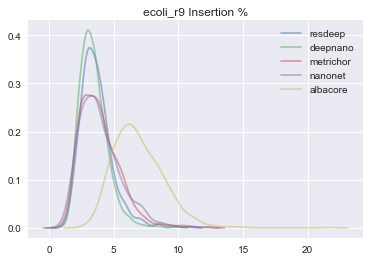

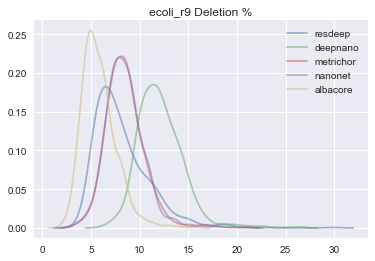

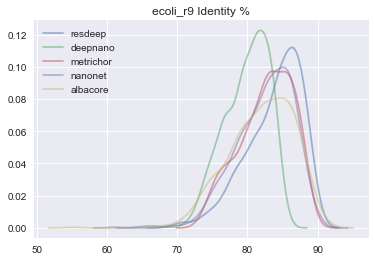

In [24]:
columns = list(iter(next(iter(dfs.values()))._get_numeric_data()))
print(columns)

fig_kde_path = os.path.join(out_dir, dataset + "reads_kde.png")
fig_hist_path = os.path.join(out_dir, dataset + "reads_hist.png")

fig_kde, axes_kde = plt.subplots(3, 2)
fig_hist, axes_hist = plt.subplots(3, 2)
fig_kde.set_size_inches(12, 20)
fig_hist.set_size_inches(12, 20)

for col, ax_kde, ax_hist in zip(columns, axes_kde.ravel(), axes_hist.ravel()):
    fig, ax = plt.subplots()
    logging.info("Plotting column %s", col)
    for k in dfs.keys():
        sns.kdeplot(dfs[k][col], shade=False, label=k, alpha=0.5, ax=ax)
        sns.kdeplot(dfs[k][col], shade=False, label=k, alpha=0.5, ax=ax_kde)
        ax_hist.hist(dfs[k][col], label=k, alpha=0.5)
    ax.set_title(dataset + " " + col)
    fig.savefig(os.path.join(out_dir, col + ".png"))
    
    for ax in [ax_kde, ax_hist]:
        ax.legend()
        ax.set_title(col)

fig_kde.savefig(fig_kde_path)
fig_hist.savefig(fig_hist_path)

INFO:root:Plotting column Match %
INFO:root:Plotting column Mismatch %
INFO:root:Plotting column Insertion %
INFO:root:Plotting column Deletion %


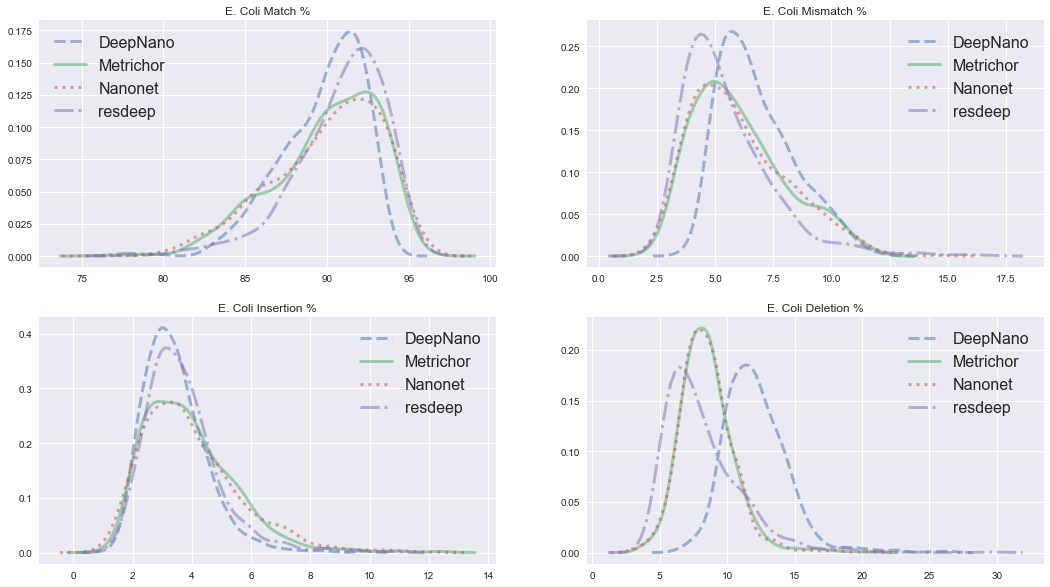

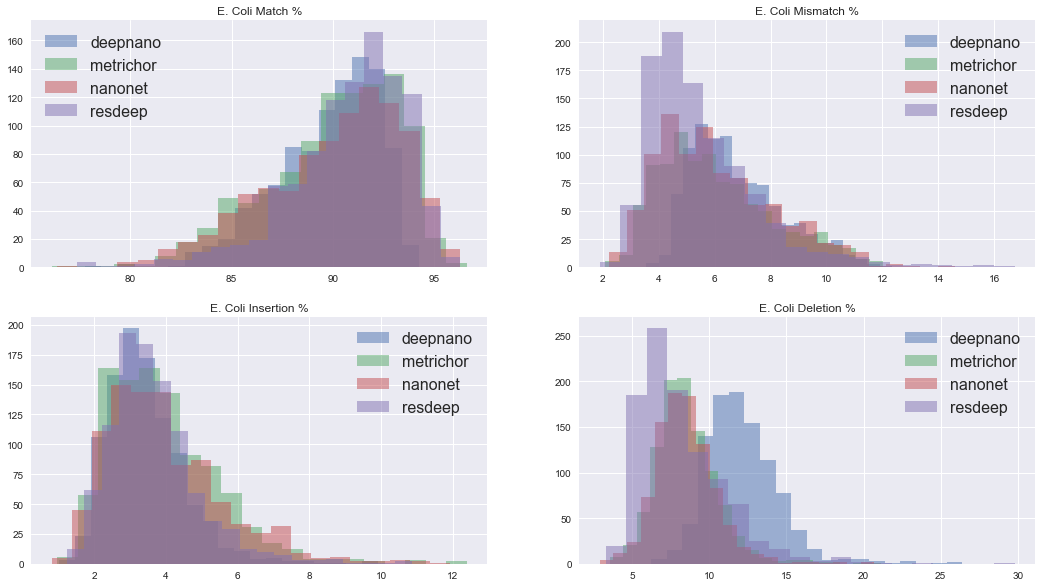

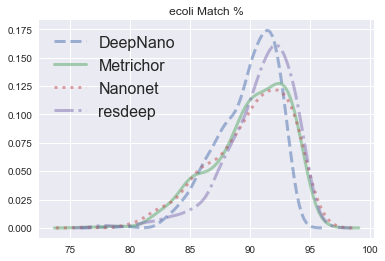

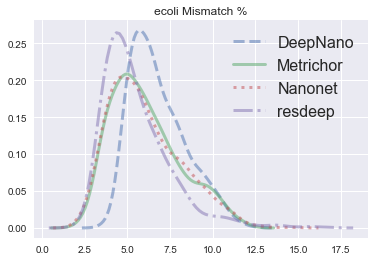

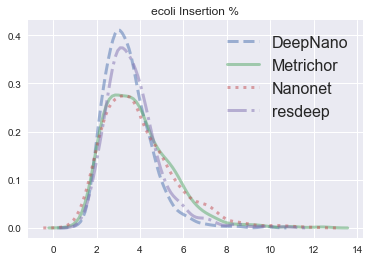

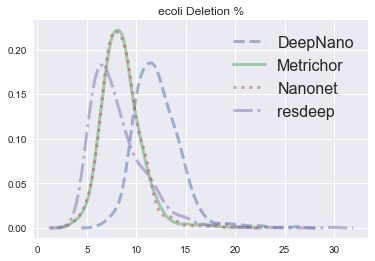

In [25]:
columns = list(iter(next(iter(dfs.values()))._get_numeric_data()))[1:-1]
df_prep = []
linestyles = ['-'] * 10
plt.rc('legend',**{'fontsize':16})
names_dict = {'deepnano':'DeepNano', 
         'nanonet': 'Nanonet', 
         'metrichor':'Metrichor', 
         'resdeep': 'resdeep'}


dataset_dict = {'lambda_R9':'lambda', 'ecoli_r9': 'E. Coli'}
fig_kde_path = os.path.join(out_dir, dataset + "reads_kde.png")
fig_hist_path = os.path.join(out_dir, dataset + "reads_hist.png")

fig_kde, axes_kde = plt.subplots(2, 2)
fig_hist, axes_hist = plt.subplots(2, 2)
fig_kde.set_size_inches(18, 10)
fig_hist.set_size_inches(18, 10)

names = []

linestyles = ['-'] + ['--', '-', ':', '-.']
for col, ax_kde, ax_hist in zip(columns, axes_kde.ravel(), axes_hist.ravel()):
    fig, ax = plt.subplots()
    logging.info("Plotting column %s", col)
    ax_kde.set_title(dataset[:-3])
    for k, stil in zip(sorted(dfs.keys()), linestyles):
        if k == 'albacore': continue
        name = names_dict[k]
        clip = None
        if col == 'Read length':
            clip = (0, 100000)
        sns.kdeplot(dfs[k][col], shade=False, label=name, alpha=0.5, ax=ax, linestyle=stil, linewidth=3,clip=clip)
        sns.kdeplot(dfs[k][col], shade=False, label=name, alpha=0.5, ax=ax_kde, linestyle=stil, linewidth=3, clip=clip)
        ax_hist.hist(dfs[k][col], label=k, alpha=0.5, bins=20, linewidth=2)
    ax.set_title(dataset[:-3] + " " + col)
    fig.savefig(os.path.join(out_dir, col + ".png"))
    for ax in [ax_kde, ax_hist]:
        ax.legend()
        ax.set_title(dataset_dict[dataset] + " " + col)
fig_kde.savefig(fig_kde_path)
fig_hist.savefig(fig_hist_path)